# Arabic QA Data Pipeline

## 1. Setup and Imports

In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import emoji
from collections import Counter

pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", palette="muted")

## 2. Data Loading

In [2]:
 df_polars = pl.read_csv("../dataset/merged_arabic_qa.csv")

In [3]:
df_polars.head()

row_id,id,question,answer,context,title,category,source_file
i64,str,str,str,str,str,str,str
0,null,""" هل نسبة المياه ببنين أقل منها…","""نعم""","""[' جمهورية بنين é é(فرنسية)…",null,null,"""acqad_comparison2.json"""
1,null,"""هل متوسط العمر بالهند أقل منه …","""نعم""","""[' الهند (بالهندية: भारत गणर…",null,null,"""acqad_comparison2.json"""
2,null,"""هل فرس البحر و النعامة ينتميان…","""لا""","""[' فرس البحرالعصر: أواخر المي…",null,null,"""acqad_comparison2.json"""
3,null,"""هل الكثافة السكانية في غانا أع…","""لا""","""[' جمهورية غانا (إنجليزية) …",null,null,"""acqad_comparison2.json"""
4,null,"""هل معدل البطالة بالصين أقل منه…","""نعم""","""[' الصين جمهورية الصين الشعب…",null,null,"""acqad_comparison2.json"""


In [9]:
len(df_polars)

200657

In [10]:
df_polars.null_count()

row_id,id,question,answer,context,title,category,source_file
u32,u32,u32,u32,u32,u32,u32,u32
0,118795,0,0,0,118795,200657,0


In [20]:
answer_empty = df_polars.filter(pl.col('answer').str.strip_chars() == '')["answer"]
answer_empty

answer
str
""""""
""""""
""""""
""""""
""""""
…
""""""
""""""
""""""


## 3. Initial Preprocessing

In [34]:
cols_to_drop = ['row_id', 'id', 'title', 'category', 'source_file']
df_polars = df_polars.drop([c for c in cols_to_drop if c in df_polars.columns])

df_polars = df_polars.filter(pl.col('answer').is_not_null())
df_polars = df_polars.filter(pl.col('answer').str.strip_chars() != '')
df_polars = df_polars.unique(subset=['question', 'context'])

## 4. Text Cleaning
Defining normalization and cleaning functions.

In [35]:
emoji_pattern = emoji.get_emoji_regexp().pattern
GARBAGE_PATTERN = r"array\(|dtype=|\{'text':|\[|\]"

cols_to_process = ["question", "answer", "context"]

for col in cols_to_process:
    df_polars = df_polars.with_columns([
        pl.col(col)
        .str.replace_all(emoji_pattern, "", literal=False)
        .str.replace_all(GARBAGE_PATTERN, "", literal=False)
        .str.replace_all(r"[\u064B-\u0652\u0640]", "", literal=False)
        .str.replace_all(r"[إأآا]", "ا", literal=False)
        .str.replace_all(r"ى", "ي", literal=False)
        .str.replace_all(r"ؤ", "و", literal=False)
        .str.replace_all(r"ئ", "ي", literal=False)
        .str.replace_all(r"ة", "ه", literal=False)
        .str.replace_all(r"[^\u0600-\u06FF0-9\s.,؟!]", " ", literal=False)
        .str.replace_all(r"\s+", " ", literal=False)
        .str.strip_chars(" ")
        .alias(col)
    ])

# Final filter after cleaning
df_polars = df_polars.filter(pl.col('answer').is_not_null())
df_polars = df_polars.filter(pl.col('answer').str.strip_chars() != "")

## 5. Feature Engineering

In [36]:
df_polars = df_polars.with_columns([
    pl.col('question').str.len_chars().alias('question_len_char'),
    pl.col('question').str.split(" ").list.len().alias('question_len_word'),
    pl.col('answer').str.len_chars().alias('answer_len_char'),
    pl.col('answer').str.split(" ").list.len().alias('answer_len_word'),
    pl.col('context').str.len_chars().alias('context_len_char')
])

In [37]:
df_polars.head()

question,answer,context,question_len_char,question_len_word,answer_len_char,answer_len_word,context_len_char
str,str,str,u32,u32,u32,u32,u32
"""هل جورجيا اكبر مساحه من جيبوتي…","""نعم""","""جمهوريه جورجيا جورجيه علم جورج…",32,7,3,1,3938
"""متي عقدت اتفاقيه تعيين الحدود …","""اتفاقيه تيران""","""اتفاقيه ترسيم الحدود البحريه ا…",55,8,13,2,215
"""ما هي موجات الجاذبيه؟""","""ان تنتهك الي حد كبير هذا النوع…","""في الفيزياء ، كان لتفكير وايته…",21,4,75,14,934
"""هل كازاخستان لها نفس نظام الحك…","""لا""","""كازاخستان بالقازاقيه علم كازاخ…",46,9,2,1,2432
"""هل ميانمار لها نفس نظام الحكم …","""لا""","""ميانمار بالانجليزيه علم ميانما…",41,9,2,1,2478


In [38]:
# Convert to Pandas for Visualization
df=df_polars.to_pandas(use_pyarrow_extension_array=True)

## 6. Exploratory

In [39]:
print(f"Dataset Shape: {df.shape}")
print(df.info())

Dataset Shape: (193509, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193509 entries, 0 to 193508
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype                
---  ------             --------------   -----                
 0   question           193509 non-null  large_string[pyarrow]
 1   answer             193509 non-null  large_string[pyarrow]
 2   context            193509 non-null  large_string[pyarrow]
 3   question_len_char  193509 non-null  uint32[pyarrow]      
 4   question_len_word  193509 non-null  uint32[pyarrow]      
 5   answer_len_char    193509 non-null  uint32[pyarrow]      
 6   answer_len_word    193509 non-null  uint32[pyarrow]      
 7   context_len_char   193509 non-null  uint32[pyarrow]      
dtypes: large_string[pyarrow](3), uint32[pyarrow](5)
memory usage: 766.0 MB
None


In [40]:
df[['question_len_char', 'question_len_word', 'answer_len_char', 'answer_len_word', 'context_len_char']].describe()

,question_len_char,question_len_word,answer_len_char,answer_len_word,context_len_char
count,193509.0,193509.0,193509.0,193509.0,193509.0
mean,45.836018,9.030402,10.104646,2.003163,2336.907115
std,16.311235,2.934055,18.837739,3.100584,2125.950289
min,0.0,1.0,1.0,1.0,7.0
25%,37.0,7.0,2.0,1.0,615.0
50%,44.0,9.0,4.0,1.0,2520.0
75%,52.0,10.0,10.0,2.0,3461.0
max,201.0,39.0,590.0,107.0,32909.0


### Distributions

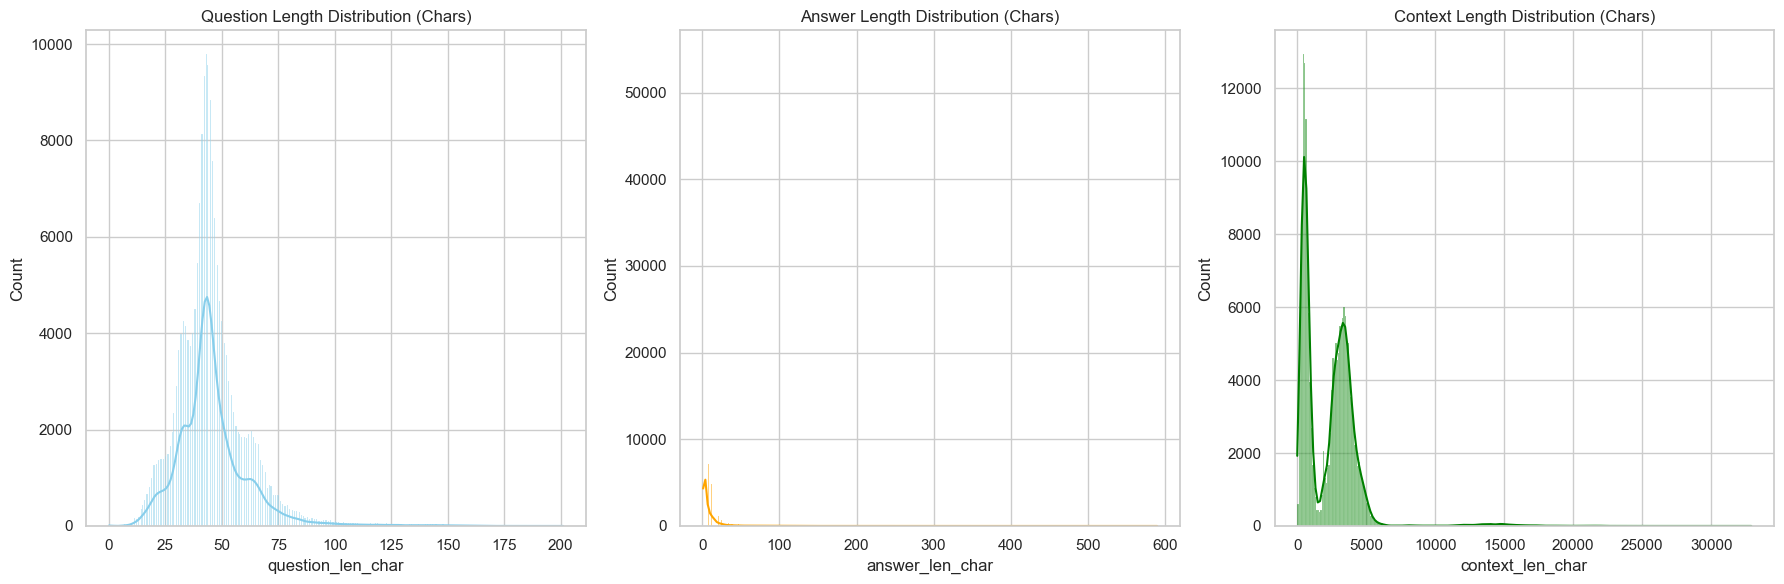

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df['question_len_char'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Question Length Distribution (Chars)')

sns.histplot(df['answer_len_char'], kde=True, ax=axes[1], color='orange')
axes[1].set_title('Answer Length Distribution (Chars)')

sns.histplot(df['context_len_char'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Context Length Distribution (Chars)')

plt.tight_layout()
plt.show()

### Top Words Analysis

In [43]:
def get_top_words(text_series, n=20):
    words = ' '.join(text_series).split()
    words = [w for w in words if len(w) > 3]
    return pd.DataFrame(Counter(words).most_common(n), columns=['word', 'count'])

In [44]:
top_q_words = get_top_words(df['question'])
top_a_words = get_top_words(df['answer'])
print(top_q_words)
print(top_a_words)

       word  count
0     مساحه  18888
1   القياده  17785
2     متوسط  17566
3      اكبر  17382
4      نظام  13844
5     الحكم  13482
6      اعلي  13422
7      نسبه  11279
8      الذي  10480
9     نفسها  10260
10     لهما   9421
11  البلدين   9352
12     هذين   9351
13     التي   8850
14     اصغر   8341
15   السكان   8334
16  البطاله   7632
17    العمر   7329
18    يحتوي   6900
19     نفسه   5753
         word  count
0     المتحده   1102
1        التي   1006
2       تساوي    978
3       مليون    756
4       غينيا    677
5       القرن    677
6     جمهوريه    672
7        جنوب    612
8    الولايات    520
9     افريقيا    461
10       اكثر    448
11       سانت    448
12   الشماليه    441
13      كوريا    422
14      دولار    406
15  الامريكيه    395
16       الذي    390
17    المانيا    337
18       مايو    333
19      فرنسا    332


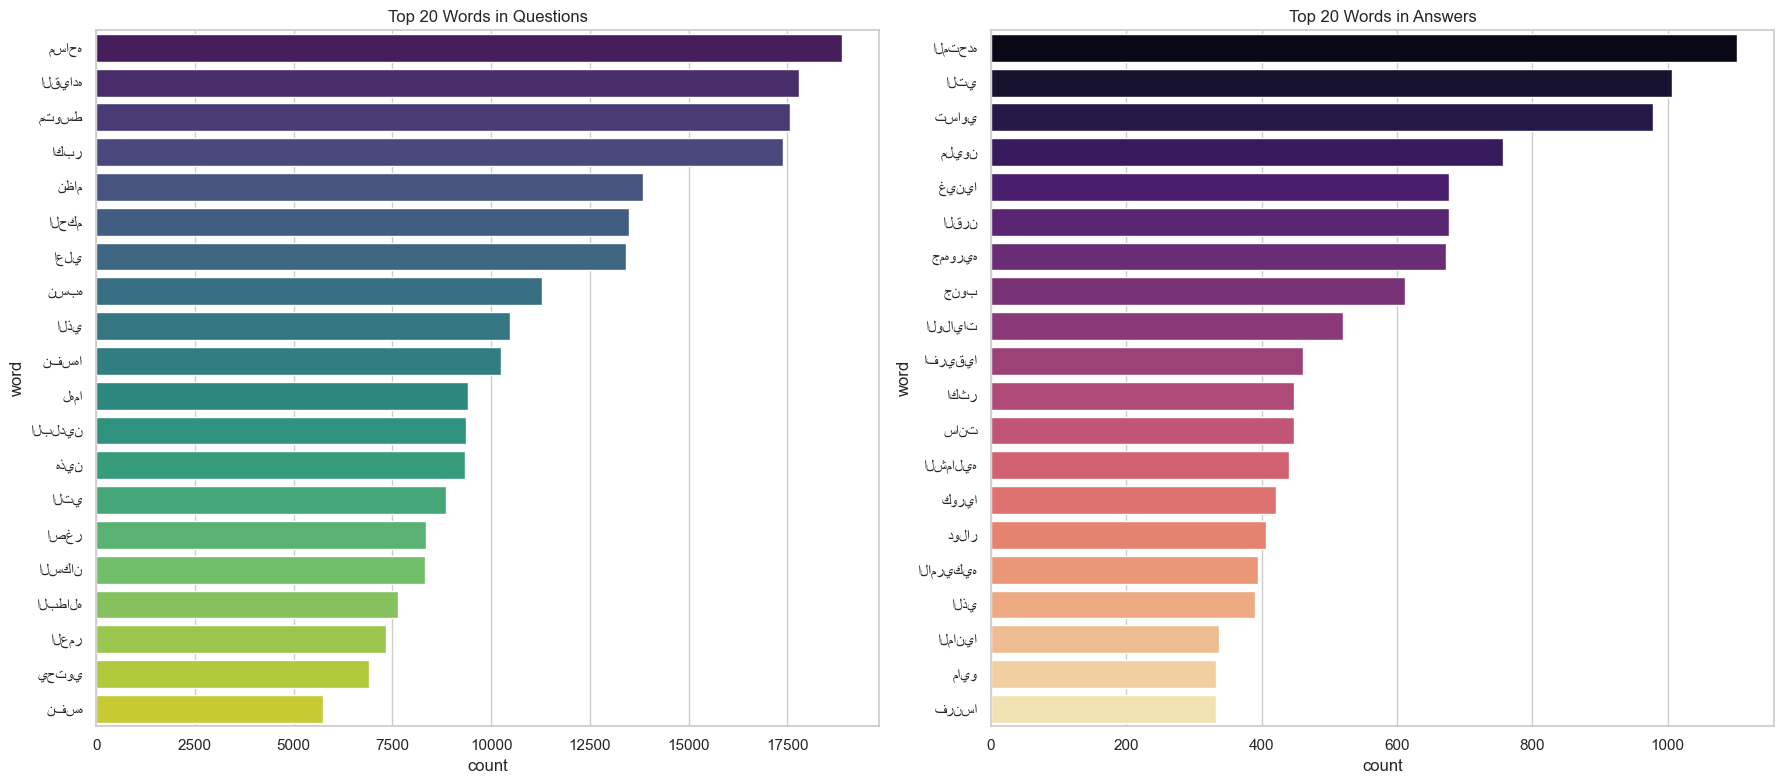

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(data=top_q_words, x='count', y='word', ax=axes[0], palette='viridis', hue='word', legend=False)
axes[0].set_title('Top 20 Words in Questions')

sns.barplot(data=top_a_words, x='count', y='word', ax=axes[1], palette='magma', hue='word', legend=False)
axes[1].set_title('Top 20 Words in Answers')

plt.tight_layout()
plt.show()

In [ ]:
df_clean.write_csv("../dataset/data_cleaned.csv")